<a href="https://colab.research.google.com/github/jkworldchampion/Military_CodingStudy/blob/main/basic_deeplearning_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 신경망 학습

In [3]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')
cd "/content/drive/MyDrive/Colab_Notebooks/Machine_learning/book/basic_deeplearning/deep-learning-from-scratch"

Mounted at /content/drive


### 오차제곱합

In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

def sum_squares_error(y, t):
    return 0.5*np.sum((y-t)**2)

print(sum_squares_error(np.array(y), np.array(t)))

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print(sum_squares_error(np.array(y), np.array(t)))

0.09750000000000003
0.5975


### 교차 엔트로피

In [16]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t*np.log(y+delta))

y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
print(cross_entropy_error(np.array(y), np.array(t)))

y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print(cross_entropy_error(np.array(y), np.array(t)))

0.510825457099338
2.302584092994546


### 미니배치 학습

In [17]:
import sys, os
from mnist import load_mnist  # 이건 손수 가져와야함.

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True)

print(x_train.shape)
print(t_train.shape)

(60000, 784)
(60000, 10)


In [18]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size) # 전체 중에 size개수만큼 선택
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [19]:
# 배치용 교차 엔트로피 오차 구현하기
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(t*np.log(y+1e-7)) / batch_size

print(cross_entropy_error(np.array(y), np.array(t)))   # 2.3025
print(np.array(y).ndim) # 1

y = np.array(y).reshape(1, np.array(y).size)
print(y)
print(y.shape)

2.302584092994546
1
[[0.1  0.05 0.1  0.   0.05 0.1  0.   0.6  0.   0.  ]]
(1, 10)


In [20]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t]+ 1e-7)) / batch_size

### 미분

In [21]:
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

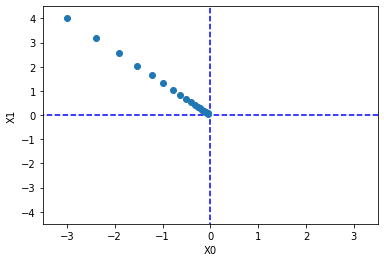

In [32]:
def _numerical_gradient_no_batch(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # x와 형상이 같은 배열을 생성
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 계산
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)
        
        # f(x-h) 계산
        x[idx] = tmp_val - h 
        fxh2 = f(x) 
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원
        
    return grad

def numerical_gradient(f, X):
    if X.ndim == 1:
        return _numerical_gradient_no_batch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_no_batch(f, x)
        
        return grad

def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    x_history = []

    for i in range(step_num):
        x_history.append( x.copy() )

        grad = numerical_gradient(f, x)
        x -= lr * grad

    return x, np.array(x_history)


def function_2(x):
    return x[0]**2 + x[1]**2

init_x = np.array([-3.0, 4.0])    

lr = 0.1
step_num = 20
x, x_history = gradient_descent(function_2, init_x, lr=lr, step_num=step_num)

plt.plot( [-5, 5], [0,0], '--b')
plt.plot( [0,0], [-5, 5], '--b')
plt.plot(x_history[:,0], x_history[:,1], 'o')

plt.xlim(-3.5, 3.5)
plt.ylim(-4.5, 4.5)
plt.xlabel("X0")
plt.ylabel("X1")
plt.show()

### 2층 신경망 클래스 구현하기

In [35]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))    

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


In [36]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads